<a href="https://colab.research.google.com/github/akatic47/Paralelni_algoritmi/blob/main/Drugi_projekat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
!pip install pycuda

KeyboardInterrupt: 

In [8]:
!nvidia-smi

Thu Dec 11 09:38:36 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   51C    P0             28W /   70W |     102MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [9]:
def diffuse_cpu(conc,decay):
    h, w = conc.shape
    conc_pad = np.pad(conc, 1, mode='constant', constant_values=0)
    conc_new = conc.copy()

    for i in range(h):
        for j in range(w):
            ip = i + 1
            jp = j + 1
            neighbors = [
                conc_pad[ip, jp],
                conc_pad[ip, jp - 1],
                conc_pad[ip, jp + 1],
                conc_pad[ip - 1, jp],
                conc_pad[ip + 1, jp]
            ]
            conc_new[i][j] = sum(neighbors) / 5 * (1-decay)

    return conc_new


In [10]:
def apply_sources_cleaners_cpu(conc, cell_type):
    h, w = conc.shape
    conc_new = conc.copy()

    for i in range(h):
        for j in range(w):
            if cell_type[i][j] == 1:
                conc_new[i][j] = source_value
            elif cell_type[i][j] == 2:
                conc_new[i][j] = absorb_value

    return conc_new


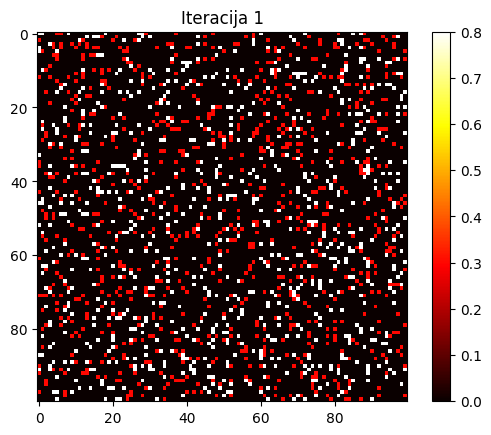

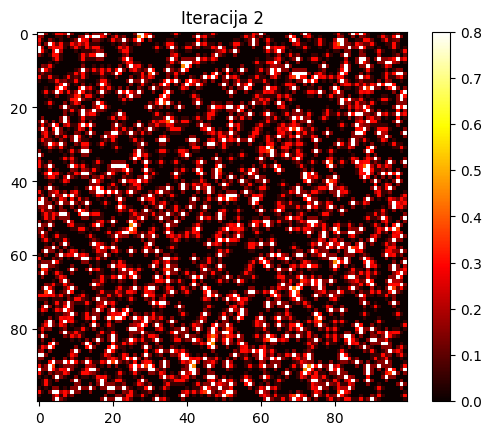

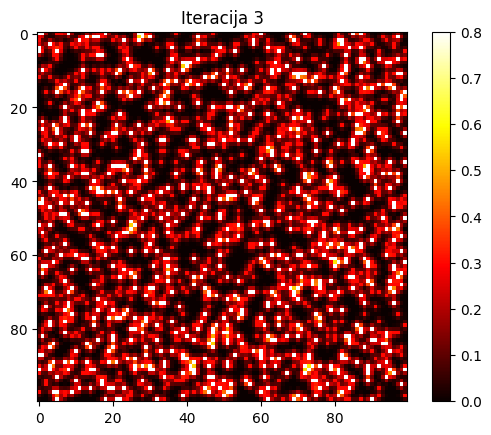

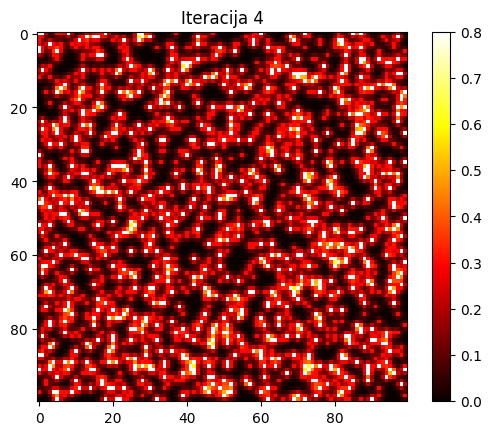

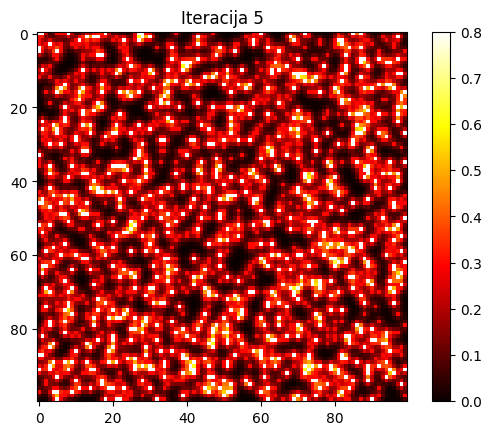

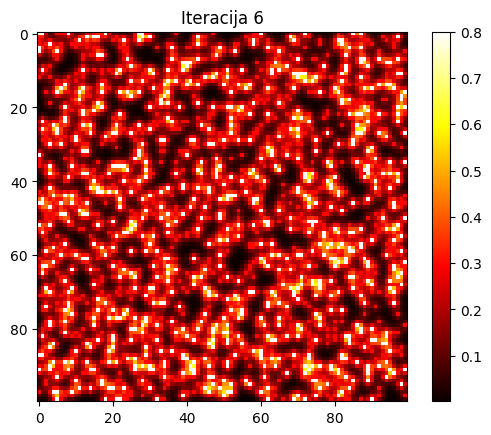

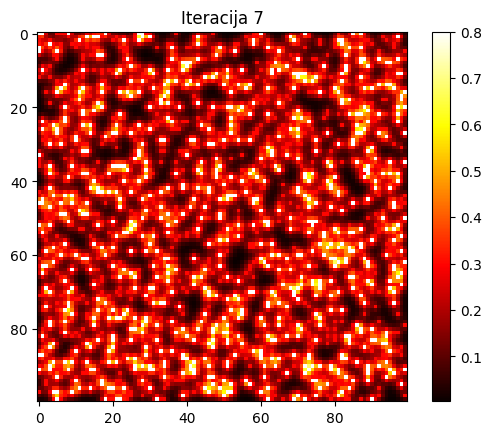

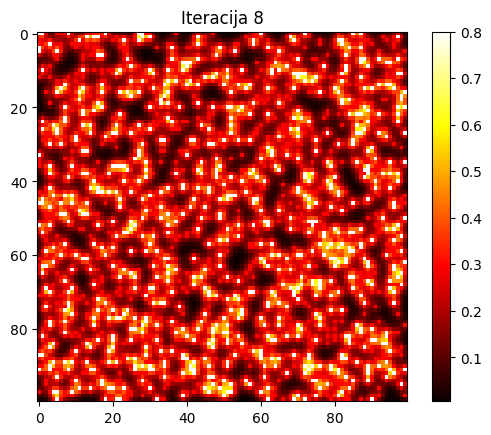

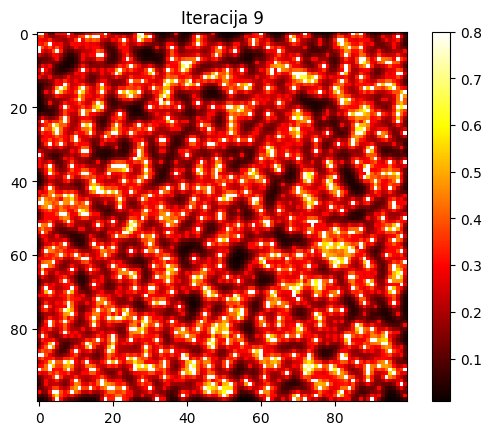

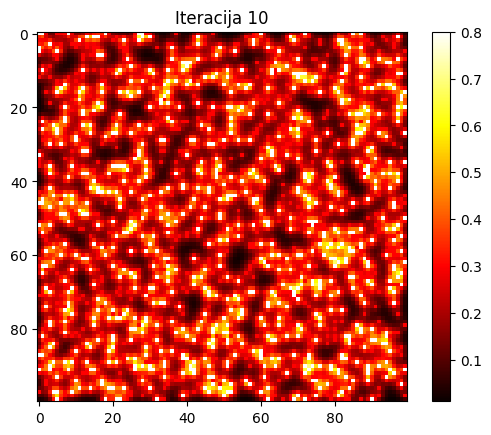

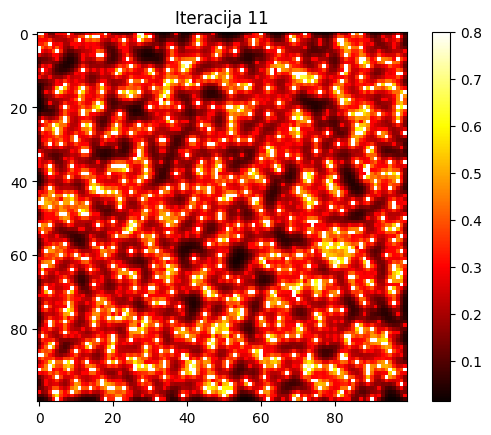

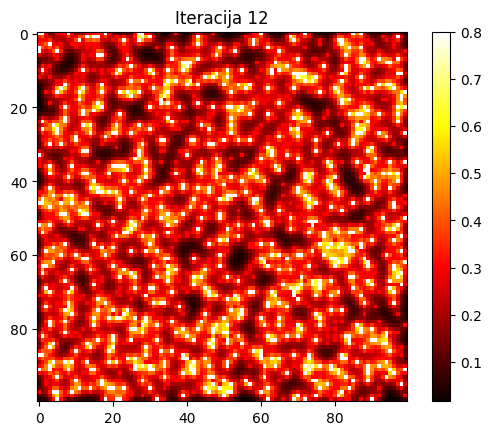

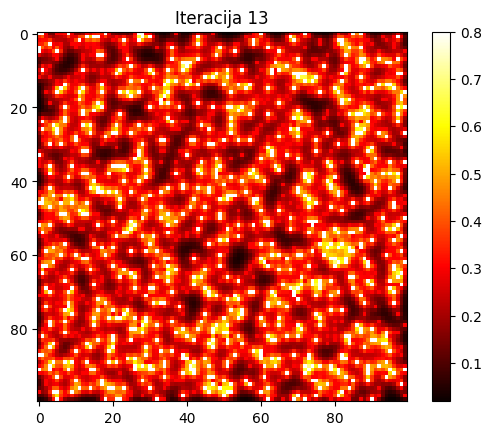

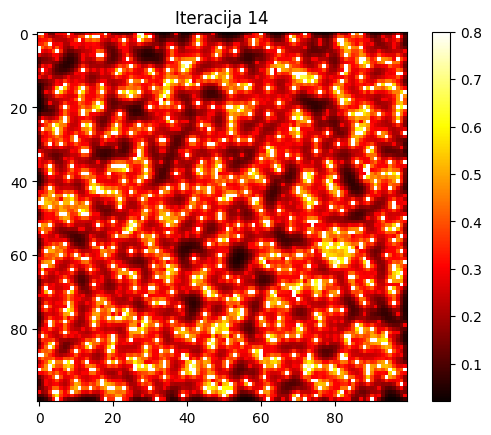

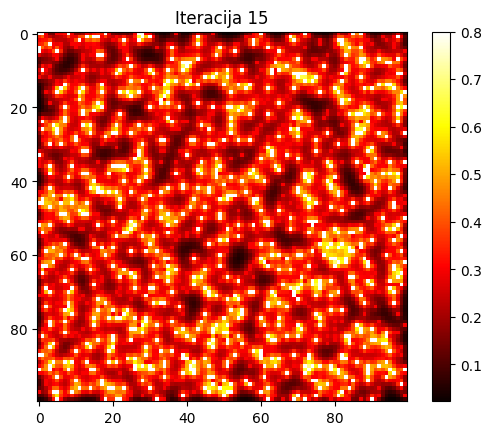

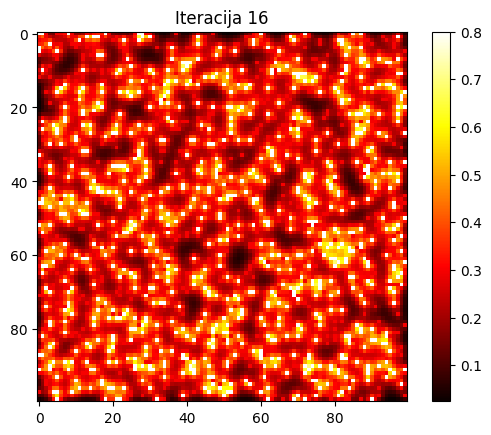

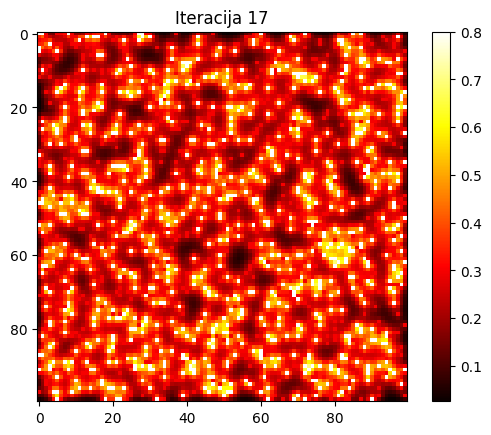

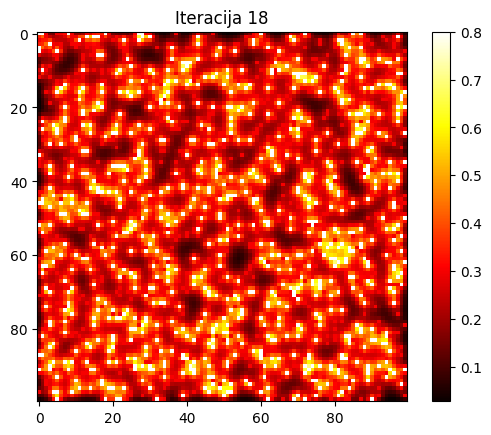

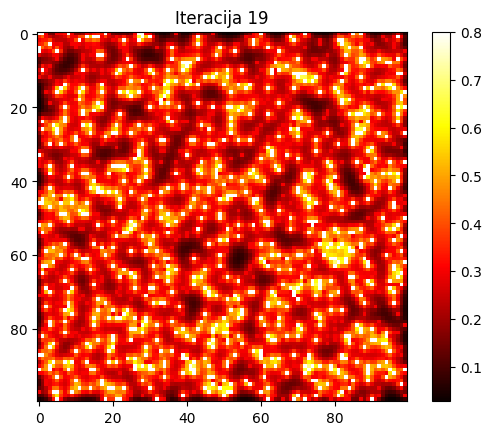

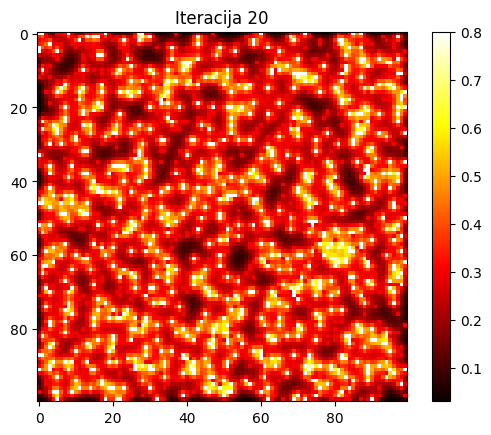

In [11]:
conc = np.zeros((h, w), dtype=np.float32)

for a in range(t):
    conc = diffuse_cpu(conc,decay)
    conc = apply_sources_cleaners_cpu(conc, cell_type)

    plt.imshow(conc, cmap='hot', interpolation='nearest')
    plt.title(f"Iteracija {a+1}")
    plt.colorbar()
    plt.show()


Prvi zadatak

In [12]:
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule
import math

Pomocne funkcije

In [13]:
def cuda_alloc(*args):
  return [cuda.mem_alloc(arg.nbytes) for arg in args]


def to_cuda(*args):
  cuda_ptrs = cuda_alloc(*args)
  for dst, src in zip(cuda_ptrs, args):
     cuda.memcpy_htod(dst, src)
  return cuda_ptrs

In [14]:
mod = SourceModule("""
__global__ void diffusion_step_kernel(float *conc_pad, float *conc_new,
                                      int h, int w, float decay)
{
    int x = threadIdx.x + blockDim.x * blockIdx.x;
    int y = threadIdx.y + blockDim.y * blockIdx.y;

    if (x >= w || y >= h) return;

    int pad_w = w + 2;
    int pad_x = x + 1;
    int pad_y = y + 1;

    int center = pad_x + pad_y * pad_w;

    float centar  = conc_pad[center];
    float levo  = conc_pad[center - 1];
    float desno  = conc_pad[center + 1];
    float gore  = conc_pad[center - pad_w];
    float dole  = conc_pad[center + pad_w];

    float avg = (centar + levo + desno + gore + dole ) / 5;
    float out = avg * (1 - decay);

    conc_new[y * w + x] = out;
}
""")

diffusion_step_kernel = mod.get_function("diffusion_step_kernel")



In [18]:
mod = SourceModule("""
__global__ void apply_sources_cleaners_kernel(
        unsigned char *cell_type,
        float *conc,
        int h, int w,
        float source_value,
        float absorb_value)
{
    int x = threadIdx.x + blockDim.x * blockIdx.x;
    int y = threadIdx.y + blockDim.y * blockIdx.y;

    if (x >= w || y >= h) return;

    int idx = y * w + x;

    unsigned char t = cell_type[idx];

    if (t == 1) {
        conc[idx] = source_value;
    }
    else if (t == 2) {
        conc[idx]-=absorb_value;
        if(conc[idx] < 0) conc[idx] = 0;
    }
}
""")

apply_sources_cleaners_kernel = mod.get_function("apply_sources_cleaners_kernel")


Drugi zadatak

In [20]:
mod = SourceModule("""
__global__ void count_danger_kernel(
        float *conc,
        int *danger_count,
        float danger_threshold,
        int h, int w)
{
    int x = threadIdx.x + blockDim.x * blockIdx.x;
    int y = threadIdx.y + blockDim.y * blockIdx.y;

    if (x >= w || y >= h) return;

    int idx = y * w + x;

    if (conc[idx] >= danger_threshold)
      danger_count[idx]++;

}
""")

count_danger_kernel = mod.get_function("count_danger_kernel")


In [39]:
mod = SourceModule("""
__global__ void count_ever_dangerous_kernel(
        int *danger_count,
        int *danger_counter,
        int h, int w)
{
    int x = threadIdx.x + blockDim.x * blockIdx.x;
    int y = threadIdx.y + blockDim.y * blockIdx.y;

    if (x >= w || y >= h) return;

    int idx = y * w + x;

    if (danger_count[idx] > 0)
      atomicAdd(danger_counter,1);

}
""")

count_ever_dangerous_kernel = mod.get_function("count_ever_dangerous_kernel")


In [41]:
import numpy as np
import random
import matplotlib.pyplot as plt


h = 20
w = 20
t = 20
decay = 0.05
source_value = 0.8
absorb_value = 0.3

danger_threshold = 0.2


cell_type = np.zeros((h,w), dtype=np.uint8)
for i in range(h):
  for j in range(w):
    cell_type[i][j] = random.choices([0, 1, 2], weights=[10, 1, 1])[0]

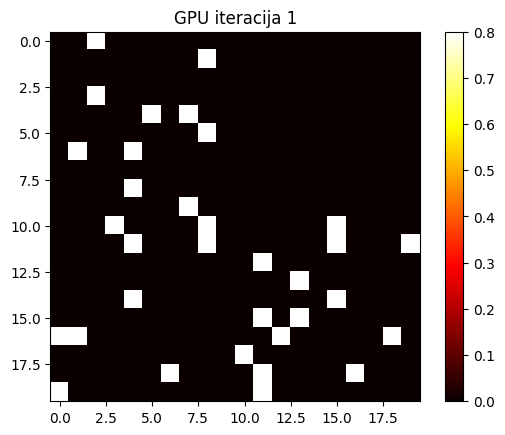

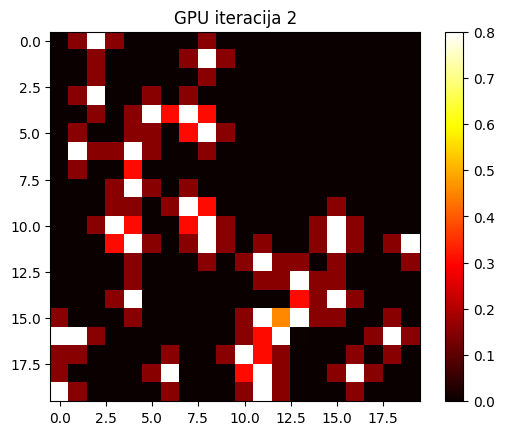

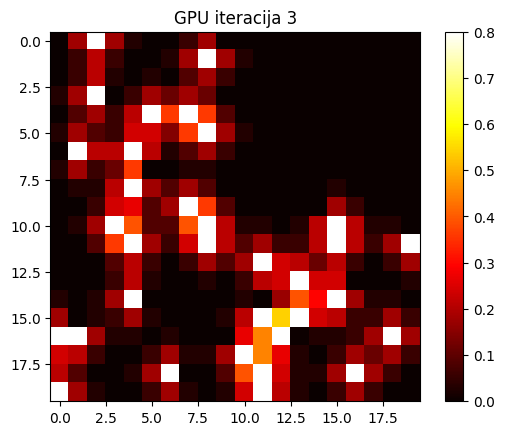

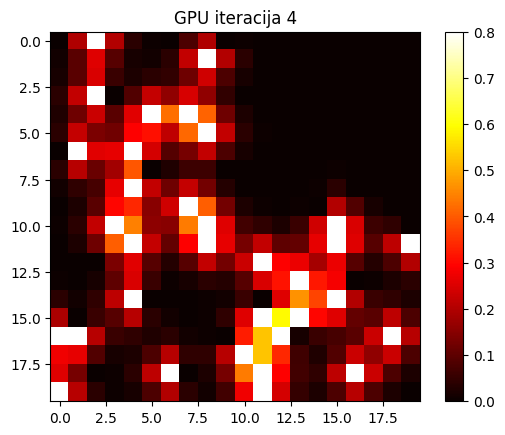

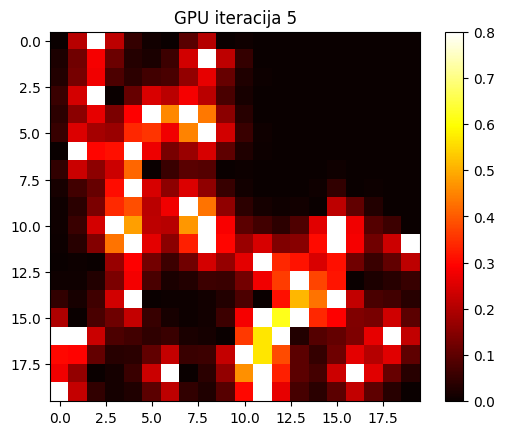

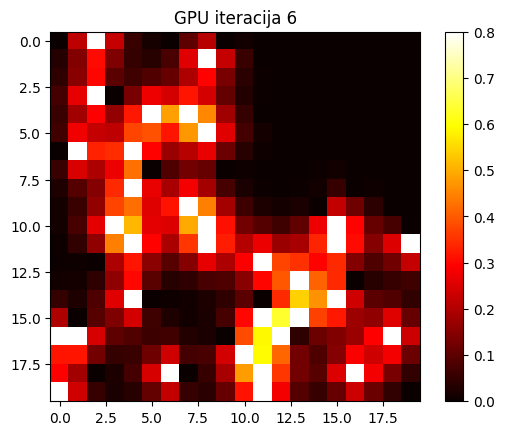

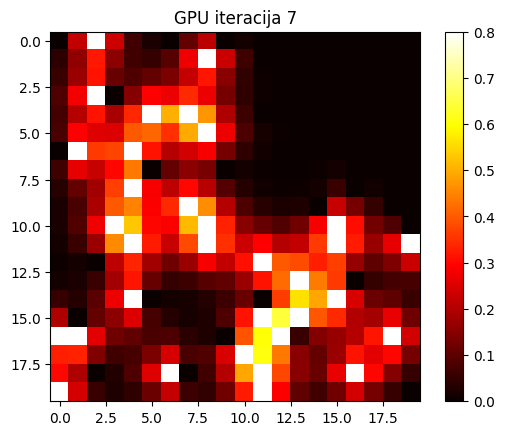

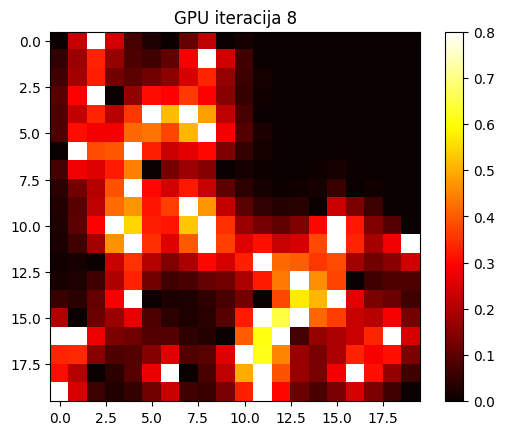

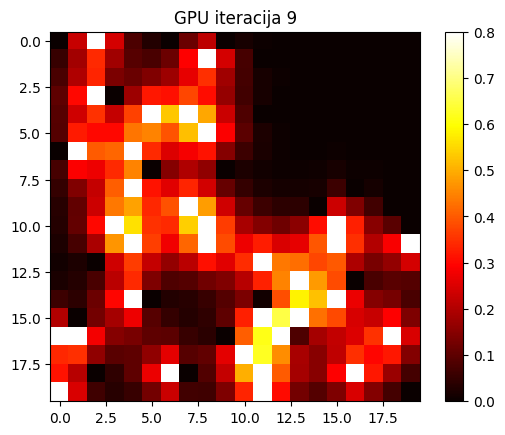

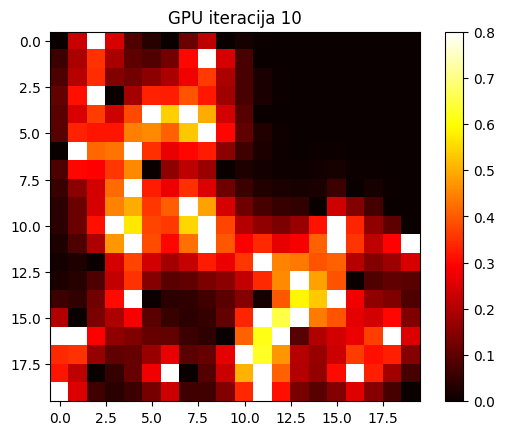

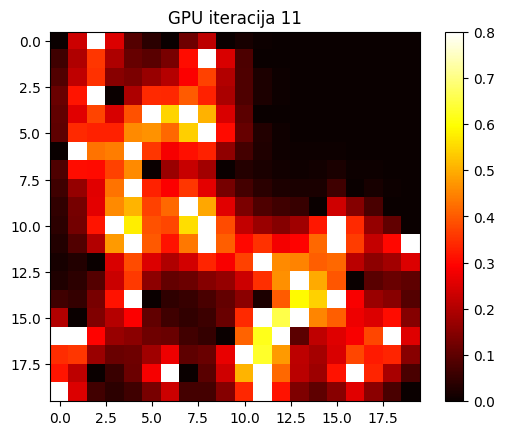

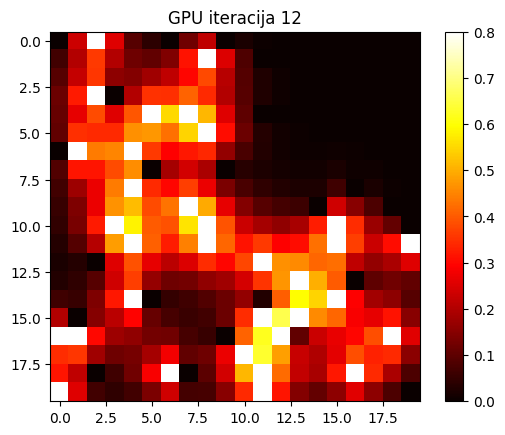

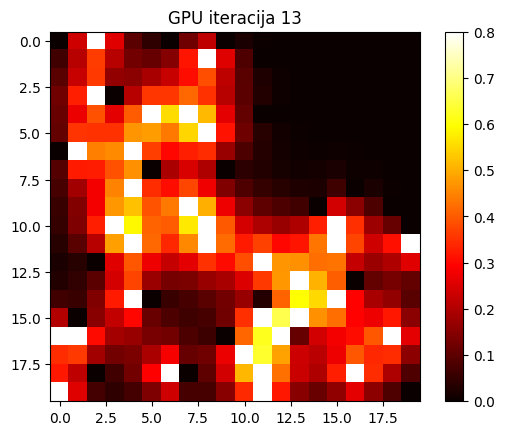

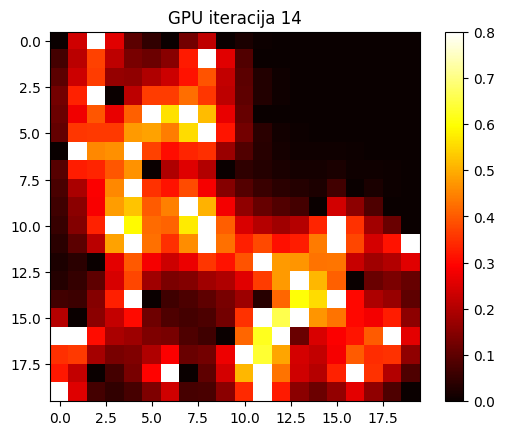

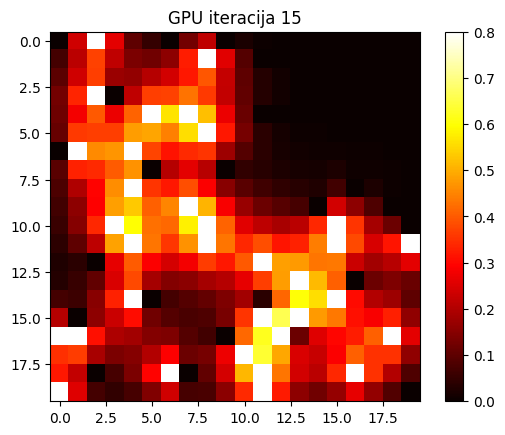

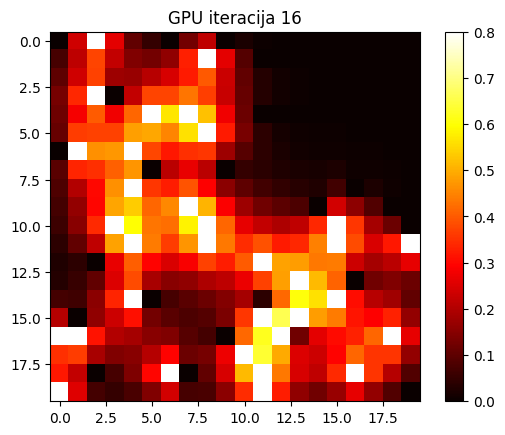

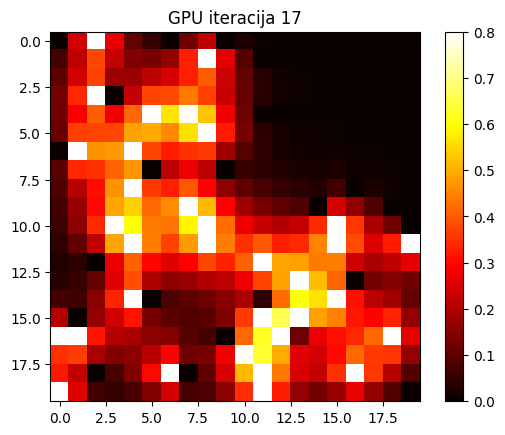

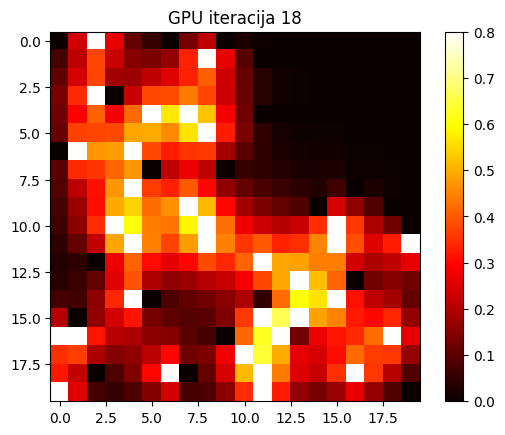

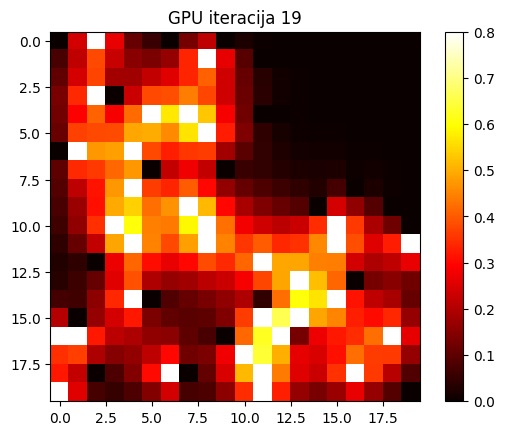

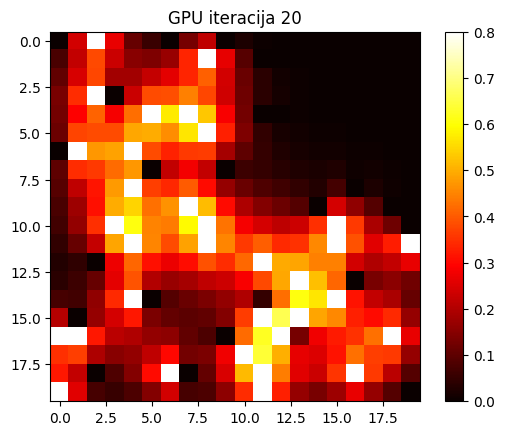

[[ 0 16 20 17  0  0  0  0 16  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  9 18  9  0  0  0 17 20 17  0  0  0  0  0  0  0  0  0  0]
 [ 0 11 18  0  0  6 10 14 17 10  0  0  0  0  0  0  0  0  0  0]
 [ 0 17 20  0  9 17 16 17 16  9  0  0  0  0  0  0  0  0  0  0]
 [ 0 14 17 13 18 20 19 20 19 13  0  0  0  0  0  0  0  0  0  0]
 [ 0 17 15 15 18 18 17 19 20 17  0  0  0  0  0  0  0  0  0  0]
 [ 0 20 18 18 20 18 14 15 17  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 17 14 16 19  0  6 11  7  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  5 13 18 20 17 14 17 14  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 13 18 18 16 17 20 19 14  0  0  0  0  0 17  0  0  0  0]
 [ 0  0 17 20 19 16 16 19 20 18 11  7  4  7 18 20 18  0  0  0]
 [ 0  0 10 19 20 17 14 18 20 18 15 17 14 14 18 20 18 12 17 20]
 [ 0  0  0 14 18 13  9 12 17 14 17 20 18 18 16 18 11  0  7 17]
 [ 0  0  0 12 18  1  0  0  4  6 12 18 18 20 18 18  0  0  0  0]
 [ 0  0  0 17 20  0  0  0  0  0  0  0 17 19 18 20 17  6  0  0]
 [13  0  0 10 17  0  0  0  0  0 18 20 19 20 18 18 14 13

In [43]:
conc = np.zeros((h, w), dtype=np.float32)
conc_gpu = cuda.mem_alloc(conc.nbytes)
cuda.memcpy_htod(conc_gpu, conc)

cell_type_gpu = cuda.mem_alloc(cell_type.nbytes)
cuda.memcpy_htod(cell_type_gpu, cell_type)

danger_count = np.zeros((h,w), dtype = np.int32)
danger_count_gpu = cuda.mem_alloc(danger_count.nbytes)
cuda.memcpy_htod(danger_count_gpu,danger_count)


danger_counter = np.zeros(1, dtype=np.int32)
danger_counter_gpu = cuda.mem_alloc(danger_counter.nbytes)
cuda.memcpy_htod(danger_counter_gpu, danger_counter)


for a in range(t):

    conc_pad = np.pad(conc, (1, 1), mode='constant', constant_values=0).astype(np.float32)
    conc_pad_gpu = cuda.mem_alloc(conc_pad.nbytes)
    cuda.memcpy_htod(conc_pad_gpu, conc_pad)


    diffusion_step_kernel(
        conc_pad_gpu, conc_gpu,
        np.int32(h), np.int32(w), np.float32(decay),
        block=(32, 32, 1),
        grid=(math.ceil(w/32), math.ceil(h/32), 1)
    )

    apply_sources_cleaners_kernel(
        cell_type_gpu, conc_gpu,
        np.int32(h), np.int32(w),
        np.float32(source_value), np.float32(absorb_value),
        block=(32, 32, 1),
        grid=(math.ceil(w/32), math.ceil(h/32), 1)
    )

    count_danger_kernel(
        conc_gpu,
        danger_count_gpu,
        np.float32(danger_threshold),
        np.int32(h),
        np.int32(w),
        block=(32, 32, 1),
        grid=(math.ceil(w/32), math.ceil(h/32), 1)
    )

    cuda.memcpy_dtoh(conc, conc_gpu)

    plt.imshow(conc, cmap='hot', interpolation='nearest')
    plt.title(f"GPU iteracija {a+1}")
    plt.colorbar()
    plt.show()



cuda.memcpy_dtoh(danger_count,danger_count_gpu)
print(danger_count)


count_ever_dangerous_kernel(
    danger_count_gpu,
    danger_counter_gpu,
    np.int32(h),
    np.int32(w),
    block=(32, 32, 1),
    grid=(math.ceil(w/32), math.ceil(h/32), 1)
)

cuda.memcpy_dtoh(danger_counter, danger_counter_gpu)
print("Broj ćelija koje su ikada bile opasne:", danger_counter[0])
